### Feature we use for this model features = ["close", "SMA_6H", "EWMA_6H", "momentum_2H", "RSI_6H","vwap"]

In [75]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau

# SBUX

## Import the data and calculate the indicator

In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import argrelextrema

# Load dataset
file_path = "/Users/artemislu/Desktop/SBUX.csv"  # Update with the different
df = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")


# Calculate the indicator
df["SMA_6H"] = df["close"].rolling(window=6).mean()  
df["EWMA_6H"] = df["close"].ewm(span=6, adjust=False).mean()  
df["momentum_2H"] = df["close"] - df["close"].shift(2) 

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["RSI_6H"] = compute_rsi(df["close"], window=6)
df=df.dropna()

In [35]:
df.head(10)

,symbol,open,high,low,close,volume,trade_count,vwap,SMA_6H,EWMA_6H,momentum_2H,RSI_6H
timestamp,,,,,,,,,,,,
2025-03-03 10:00:00+00:00,SBUX,115.75,115.75,115.75,115.75,361.0,27.0,115.750000,115.676667,115.693167,0.07,57.142857
2025-03-03 11:26:00+00:00,SBUX,115.74,115.75,115.74,115.75,449.0,17.0,115.743478,115.683333,115.709405,0.09,57.142857
2025-03-03 12:05:00+00:00,SBUX,115.70,115.72,115.70,115.72,573.0,20.0,115.714286,115.701667,115.712432,-0.03,76.190476
2025-03-03 12:07:00+00:00,SBUX,115.74,115.75,115.74,115.75,376.0,10.0,115.745455,115.718333,115.723166,0.00,75.000000
2025-03-03 12:16:00+00:00,SBUX,115.76,115.77,115.76,115.77,636.0,20.0,115.767537,115.733333,115.736547,0.05,73.684211
2025-03-03 12:29:00+00:00,SBUX,115.77,115.78,115.75,115.75,735.0,28.0,115.770000,115.748333,115.740391,0.00,73.684211
2025-03-03 12:35:00+00:00,SBUX,115.65,115.65,115.65,115.65,302.0,3.0,115.650000,115.731667,115.714565,-0.12,25.000000
2025-03-03 12:47:00+00:00,SBUX,115.76,115.77,115.76,115.77,459.0,4.0,115.765643,115.735000,115.730403,0.02,53.125000
2025-03-03 12:55:00+00:00,SBUX,115.78,115.78,115.78,115.78,367.0,21.0,115.780000,115.745000,115.744574,0.13,60.000000


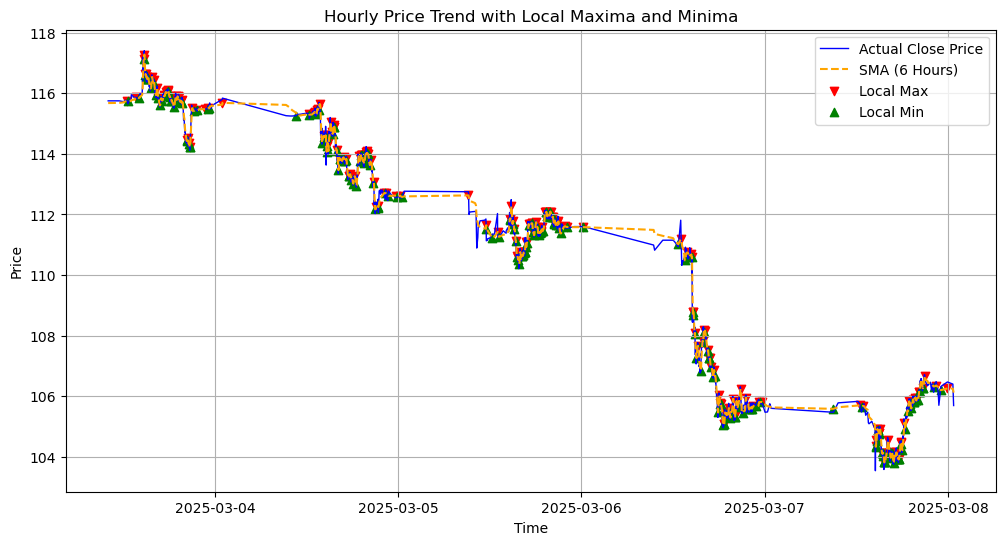

In [65]:
import matplotlib.pyplot as plt
# local maximum
local_max_idx = argrelextrema(df ["SMA_6H"].values, np.greater, order=3)[0]
df.loc[df .iloc[local_max_idx].index, "Local_Max"] = df["SMA_6H"]

# local minimum
local_min_idx = argrelextrema(df["SMA_6H"].values, np.less, order=3)[0]
df .loc[df .iloc[local_min_idx].index, "Local_Min"] = df["SMA_6H"]

# Visualization
plt.figure(figsize=(12,6))
plt.plot(df .index, df["close"], label="Actual Close Price", color="blue", linewidth=1)
plt.plot(df .index, df["SMA_6H"], label="SMA (6 Hours)", color="orange", linestyle="dashed")
plt.scatter(df.index, df["Local_Max"], color="red", marker="v", label="Local Max")
plt.scatter(df .index, df ["Local_Min"], color="green", marker="^", label="Local Min")

plt.title("Hourly Price Trend with Local Maxima and Minima")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [67]:
# Feature selection
features = ["close", "SMA_6H", "EWMA_6H", "momentum_2H", "RSI_6H","vwap"]

#Data deal
df_trainnew= df # use all data to train the model
scaler = MinMaxScaler()
df_trainnew[features] = scaler.fit_transform(df_trainnew[features])

data_scaled = df_trainnew[features].values
past_minutes = 120 
future_minutes = 60  


print("Data Traninged")

df_trainnew[features]

Data Traninged


,close,SMA_6H,EWMA_6H,momentum_2H,RSI_6H,vwap
timestamp,,,,,,
2025-03-03 10:00:00+00:00,0.880635,0.881139,0.882726,0.570616,0.571429,0.881860
2025-03-03 11:26:00+00:00,0.880635,0.881633,0.883932,0.578680,0.571429,0.881385
2025-03-03 12:05:00+00:00,0.878471,0.882993,0.884157,0.530299,0.761905,0.879262
2025-03-03 12:07:00+00:00,0.880635,0.884228,0.884954,0.542394,0.750000,0.881529
2025-03-03 12:16:00+00:00,0.882077,0.885340,0.885947,0.562553,0.736842,0.883135
...,...,...,...,...,...,...
2025-03-07 22:49:00+00:00,0.155788,0.179694,0.173274,0.227916,0.345679,0.150910
2025-03-07 23:05:00+00:00,0.200505,0.178582,0.177129,0.618998,0.477833,0.196003
2025-03-07 23:56:00+00:00,0.211323,0.182782,0.183065,0.852840,0.589474,0.206913


In [ ]:
# Create LSTM Traning model
def create_sequences(data, past_minutes=120, future_minutes=60):
    X, y = [], []
    for i in range(len(data) - past_minutes - future_minutes):
        X.append(data[i:i + past_minutes])  # past 120 minures in our case
        y.append(data[i + past_minutes: i + past_minutes + future_minutes, 1])  # pridect next 60 minutes

    return np.array(X), np.array(y)


X_train, y_train = create_sequences(data_scaled, past_minutes, future_minutes)

num_features = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], num_features)

# LSTM Model with hyperpremeter after tunning
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, input_shape=(past_minutes, num_features))),
    Dropout(0.4),
    Bidirectional(LSTM(192, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation="relu"),
    Dense(future_minutes)  
])

# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[lr_scheduler], verbose=1)

# save our model
model_path = "lstm_local_extrema_SBUX.h5"
model.save(model_path)
print(f"Aleary saved: {model_path}")

# Model for C

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import argrelextrema


# Load dataset
file_path = "/Users/artemislu/Desktop/C.csv"  # Update with the different
df = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")


# Calculate the indicator
df["SMA_6H"] = df["close"].rolling(window=6).mean()  
df["EWMA_6H"] = df["close"].ewm(span=6, adjust=False).mean()  
df["momentum_2H"] = df["close"] - df["close"].shift(2) 

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["RSI_6H"] = compute_rsi(df["close"], window=6)
df=df.dropna()

# Feature selection
features = ["close", "SMA_6H", "EWMA_6H", "momentum_2H", "RSI_6H","vwap"]

#Data deal
df_trainnew= df # use all data to train the model
scaler = MinMaxScaler()
df_trainnew[features] = scaler.fit_transform(df_trainnew[features])

data_scaled = df_trainnew[features].values
past_minutes = 120 
future_minutes = 60  

# Create LSTM Traning model
def create_sequences(data, past_minutes=120, future_minutes=60):
    X, y = [], []
    for i in range(len(data) - past_minutes - future_minutes):
        X.append(data[i:i + past_minutes])  # past 120 minures in our case
        y.append(data[i + past_minutes: i + past_minutes + future_minutes, 1])  # pridect next 60 minutes

    return np.array(X), np.array(y)


X_train, y_train = create_sequences(data_scaled, past_minutes, future_minutes)

num_features = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], num_features)

# LSTM Model with hyperpremeter after tunning
model = Sequential([
    Bidirectional(LSTM(252, return_sequences=True, input_shape=(past_minutes, num_features))),
    Dropout(0.4),
    Bidirectional(LSTM(126, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation="relu"),
    Dense(future_minutes)  
])

# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[lr_scheduler], verbose=1)

# save our model
model_path = "lstm_local_extrema_C.h5"
model.save(model_path)
print(f"Aleary saved: {model_path}")

# Model for NVDA

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import argrelextrema

# Load dataset
file_path = "/Users/artemislu/Desktop/NVDA.csv"  # Update with the different
df = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")


# Calculate the indicator
df["SMA_6H"] = df["close"].rolling(window=6).mean()  
df["EWMA_6H"] = df["close"].ewm(span=6, adjust=False).mean()  
df["momentum_2H"] = df["close"] - df["close"].shift(2) 

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["RSI_6H"] = compute_rsi(df["close"], window=6)
df=df.dropna()

# Feature selection
features = ["close", "SMA_6H", "EWMA_6H", "momentum_2H", "RSI_6H","vwap"]

#Data deal
df_trainnew= df # use all data to train the model
scaler = MinMaxScaler()
df_trainnew[features] = scaler.fit_transform(df_trainnew[features])

data_scaled = df_trainnew[features].values
past_minutes = 120 
future_minutes = 60  

# Create LSTM Traning model
def create_sequences(data, past_minutes=120, future_minutes=60):
    X, y = [], []
    for i in range(len(data) - past_minutes - future_minutes):
        X.append(data[i:i + past_minutes])  # past 120 minures in our case
        y.append(data[i + past_minutes: i + past_minutes + future_minutes, 1])  # pridect next 60 minutes

    return np.array(X), np.array(y)


X_train, y_train = create_sequences(data_scaled, past_minutes, future_minutes)

num_features = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], num_features)

# LSTM Model with hyperpremeter after tunning
model = Sequential([
    Bidirectional(LSTM(252, return_sequences=True, input_shape=(past_minutes, num_features))),
    Dropout(0.4),
    Bidirectional(LSTM(126, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation="relu"),
    Dense(future_minutes)  
])

# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[lr_scheduler], verbose=1)

# save our model
model_path = "lstm_local_extrema_NVDA.h5"
model.save(model_path)
print(f"Aleary saved: {model_path}")